# Goal: find the CMZ absolute path length difference using visibilities from the original analysis code

#### Import modules and files

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import uncertainties
import pickle
import pandas as pd
from numba import njit

In [60]:
#load the spot parameters
#For some reason, the csv loads in all elements as single strings, so the list structure inside
# columns like hist_vals is not preserved. This makes it easier to just use the pickle files and the spot_df
# just for displaying text. spot_df can itself be unpacked, making it annoying to play nice with 
# the zip() and enumerate() functions for other iterables

spot_df = pd.read_csv('spot_csv.csv')

#### Put the visibility values and bin centers into arrays

In [61]:
#bin locations
bin_centers_rt = []
with open('input_bin_centers.dat','r') as f:
    for row in f:
        bin_centers_rt.append(float(row))
bin_centers_rt = np.array(bin_centers_rt)

#visibility histogram values
hist_vals = []
for i, spot in spot_df.iloc[::2].iterrows():
    file_name = f"hist_bin_paper_{spot['wavelength(nm)']}_vis.pkl"
    with open(file_name, 'rb') as f:
        hist_vals.append(pickle.load(f))
        print(f"Added {file_name} to hist_vals")
hist_vals = np.array(hist_vals)

Added hist_bin_paper_696.54_vis.pkl to hist_vals
Added hist_bin_paper_706.72_vis.pkl to hist_vals
Added hist_bin_paper_714.7_vis.pkl to hist_vals
Added hist_bin_paper_727.29_vis.pkl to hist_vals
Added hist_bin_paper_738.4_vis.pkl to hist_vals
Added hist_bin_paper_750.39_vis.pkl to hist_vals
Added hist_bin_paper_763.51_vis.pkl to hist_vals
Added hist_bin_paper_772.38_vis.pkl to hist_vals
Added hist_bin_paper_794.82_vis.pkl to hist_vals
Added hist_bin_paper_801.48_vis.pkl to hist_vals
Added hist_bin_paper_811.53_vis.pkl to hist_vals
Added hist_bin_paper_826.45_vis.pkl to hist_vals
Added hist_bin_paper_842.46_vis.pkl to hist_vals
Added hist_bin_paper_852.14_vis.pkl to hist_vals


#### Manually find the bounds of the data used for determining the phase.

left index is 14 and right index is 482. The limited histograms have 468 indices.


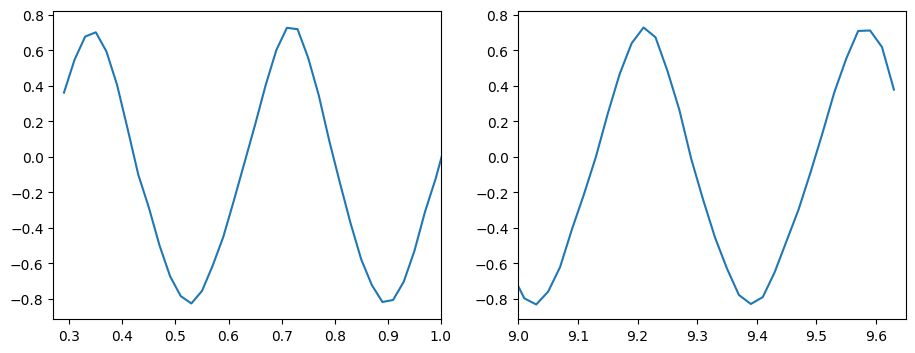

In [62]:
left_lim = 0.27
right_lim = 9.65
  
#calculate the indices to use
dt = 2. * bin_centers_rt[0]
left_index = int(np.ceil(left_lim/dt))
right_index = int(np.floor(right_lim/dt))

#graph sections of the result at the edges
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))
ax[0].plot(bin_centers_rt[left_index:right_index],hist_vals[0][left_index:right_index])
ax[0].set_xlim(left_lim,1)
ax[1].plot(bin_centers_rt[left_index:right_index],hist_vals[0][left_index:right_index])
ax[1].set_xlim(9,right_lim)

#Use the cut-down histograms and x-values for the phase determination
limited_hist_vals = []
for hist in hist_vals:
    limited_hist_vals.append(hist[left_index:right_index])
limited_centers = bin_centers_rt[left_index:right_index]

print(f"left index is {left_index} and right index is {right_index}. The limited histograms have {len(limited_hist_vals[0])} indices.")

#### Define models 

#### -Don't interpret a repeated parameter labels to always mean the same thing.

#### -MUST name the (fundamental) angular frequency "angfreq" and the phase "phase"!

In [63]:
#Note: Defaults for param attributes. We are concerned with value, min, and max
# value = None
# vary = True
# min = -inf #(we set this using np.inf)
# max = inf #(we set this using np.inf)
# expr = None
# brute_step = None
# user_data = None

#FIXME: maybe edits functions can be used when accounting for the phase shifts due to the fibers or BS that the light goes through.

#FIRST MODEL: pure sine
def pure_sinusoid_function(x, a, angfreq, phase, d):
    return a*np.sin(angfreq*x + phase) + d
    
def pure_sinusoid_guesses(hist_index):
    hist = limited_hist_vals[hist_index]
    d = np.mean(hist)
    a = np.max(hist) - d
    angfreq = 2.*np.pi*spot_df.iloc[hist_index]['expected_freq_max(inv min)']
    phase = 0.2255
    return (a, angfreq, phase, d)

#FIXME: how do I make constraints work in this way with the commented out line two blocks from here?
def pure_sinusoid_constrained_params(model, g): #g is the guess function.
    g0 = g[0]
    g1 = g[1]
    g2 = g[2]
    g3 = g[3]
    model.make_params(a=dict(value=g0,min=-np.inf,max=np.inf),
                      angfreq=dict(value=g1,min=-np.inf,max=np.inf),
                      phase=dict(value=g2),
                      d=dict(value=g3))
    
pure_sinusoid_model = lmfit.Model(pure_sinusoid_function)


#SECOND MODEL: like a sine to a power; looks like the non-sineliness we see in the data
def nl_power_sinusoid_function(x, a, angfreq, phase, d, e):
    return (a*np.sin(angfreq*x+phase) + a)**np.fabs(e) + d
    
def nl_power_sinusoid_guesses(hist_index):
    hist = limited_hist_vals[hist_index]
    d = np.mean(hist)
    a = np.max(hist) - d
    angfreq = 2*np.pi*spot_df.iloc[hist_index]['freq_max(inv min)']
    phase = 0.8
    e = 0.5
    return (a, angfreq, phase, d, e)

def nl_power_sinusoid_constrained_params(model):
    #model.create_params()
    pass
    
nl_power_sinusoid_model = lmfit.Model(nl_power_sinusoid_function)


#THIRD MODEL: lowest 2 terms of fourier series with fixed phase and fundamental freq
def two_term_fourier_function(x, a, angfreq, phase, d, g):
    return a*np.sin(angfreq*x + phase) + g*np.sin(2.*angfreq*x + phase) + d
    
def two_term_fourier_guesses(hist_index):
    hist = limited_hist_vals[hist_index]
    d = np.mean(hist)
    a = np.max(hist) - d
    angfreq = 2*np.pi*spot_df.iloc[hist_index]['freq_max(inv min)']
    phase = np.pi
    g = 0.0
    return (a, angfreq, phase, d, g)

def two_term_fourier_constrained_params(model):
    #model.create_params()
    pass

two_term_fourier_model = lmfit.Model(two_term_fourier_function)

#### Choose a model

In [64]:
#choose a model function
selected_function = pure_sinusoid_function

#match guesses and Model
if selected_function == pure_sinusoid_function:
    guesses = pure_sinusoid_guesses
    model = pure_sinusoid_model
    constrained_params = pure_sinusoid_constrained_params
elif selected_function == nl_power_sinusoid_function:
    guesses = nl_power_sinusoid_guesses
    model = nl_power_sinusoid_model
    constrained_params = nl_power_sinusoid_constrained_params
elif selected_function == two_term_fourier_function:
    guesses = two_term_fourier_guesses
    model = two_term_fourier_model
    constrained_params = two_term_fourier_constrained_params

#### Create fits for all spots

At this time, only pure_sinusoid doesn't produce NaNs and crash. It also doesn't generate good fits for the visibility plots like it does for the counts plots. I should run both of these codes on the data from each experiment.

In [65]:
#define a fit using lmfit, not scipy for an accurate covariance matrix

#Mostly working methods: differential_evolution, basinhopping, ampgo, dual_annealing

results = []
for i, hist in enumerate(limited_hist_vals):   
    #params = constrained_params(model, guesses(i))
    params = model.make_params() #these commented-out lines act as the above line without general constraint-setting
    specific_guesses = guesses(i)
    for pname, guess in zip(params.valuesdict().keys(), specific_guesses):
        params[pname].set(guess)
    ### trying stuff ###FIXME: rewrite this in a more general way; ideally by making the commented out line work alone
    params['a'].set(min=params['a'].value*0.8,max=params['a'].value*1.2)
    params['angfreq'].set(min=params['angfreq'].value*0.9,max=params['angfreq'].value*1.4)
    params['phase'].set(min=-np.pi,max=2*np.pi)
    params['d'].set(min=params['d'].value*0.9,max=params['d'].value*1.1)
    ###
    result = model.fit(hist,params,x=limited_centers,method='ampgo') #FIXME: add a weight representing uncertainty after params
    results.append(result)

C:\Users\tdavd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


#### Graph the fits with the data

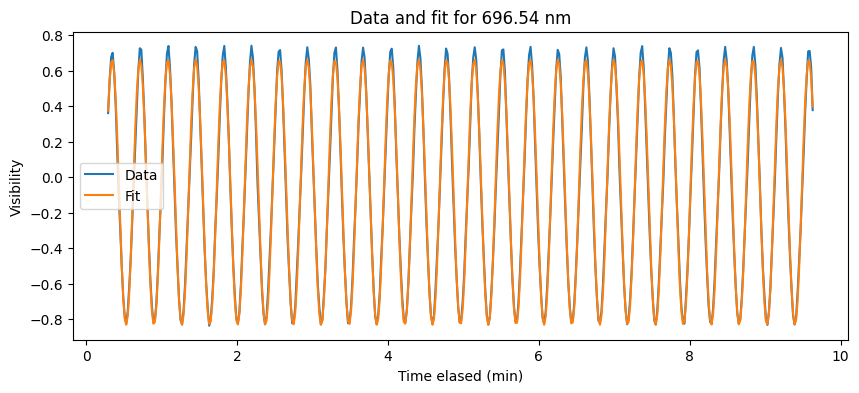

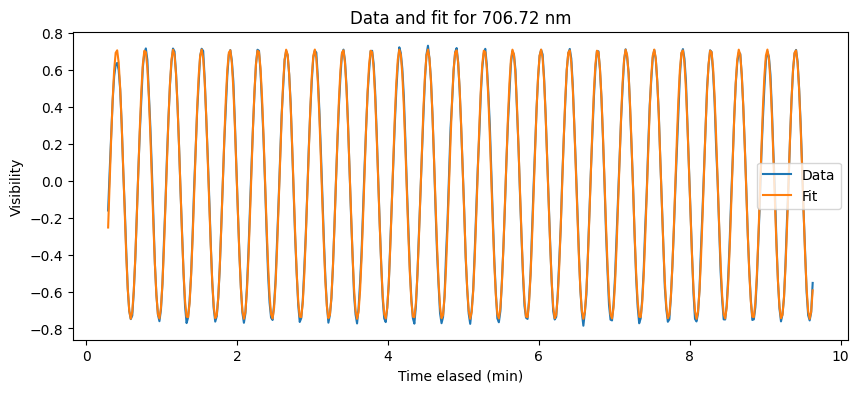

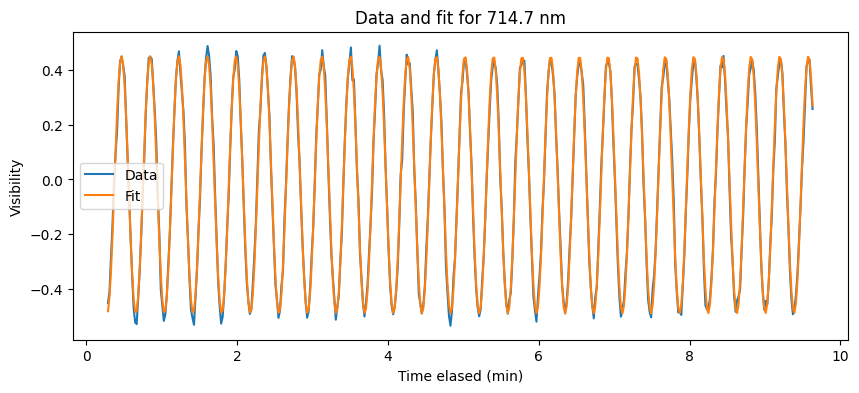

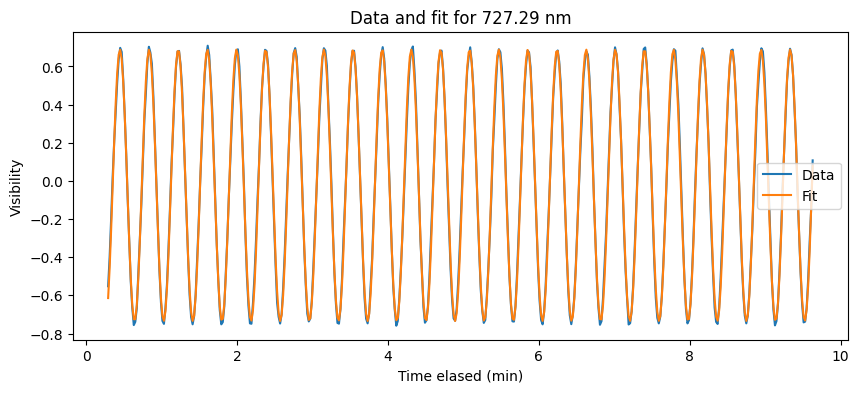

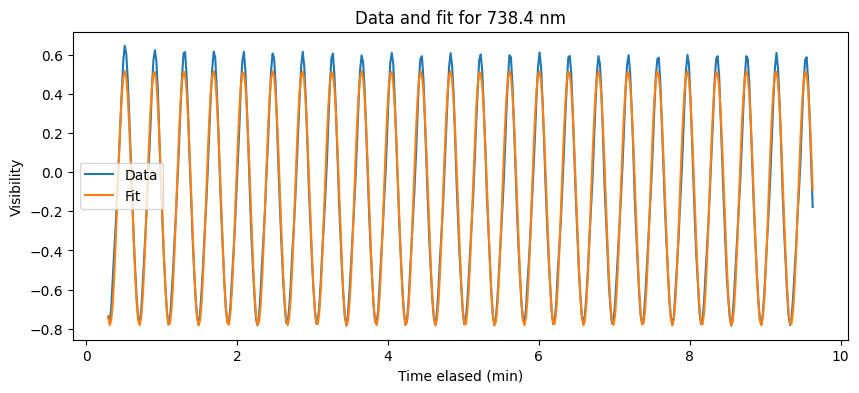

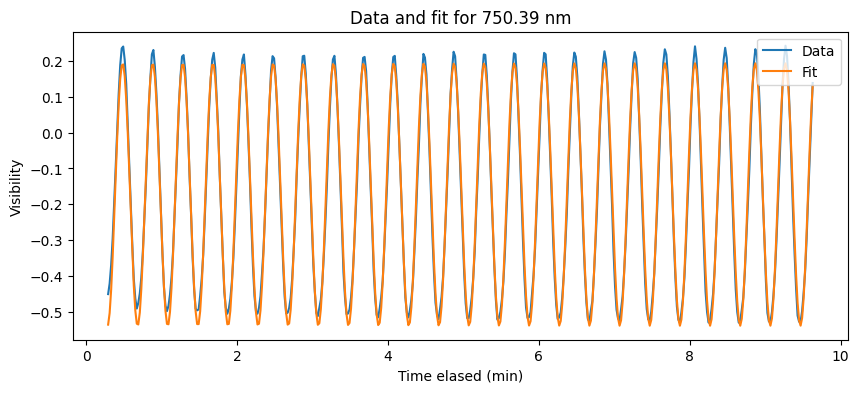

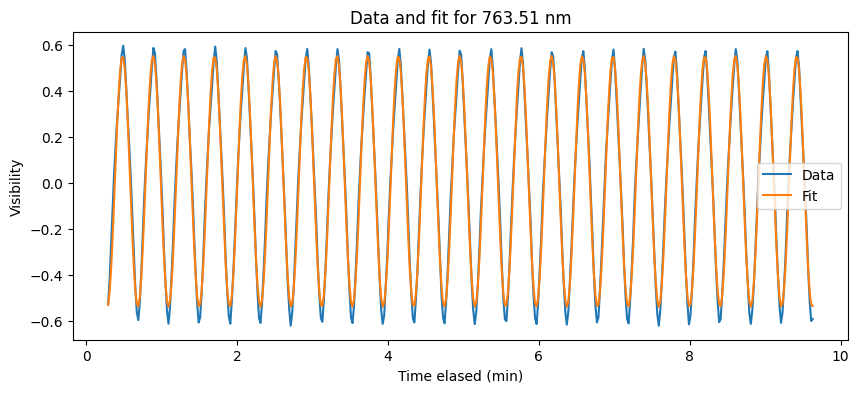

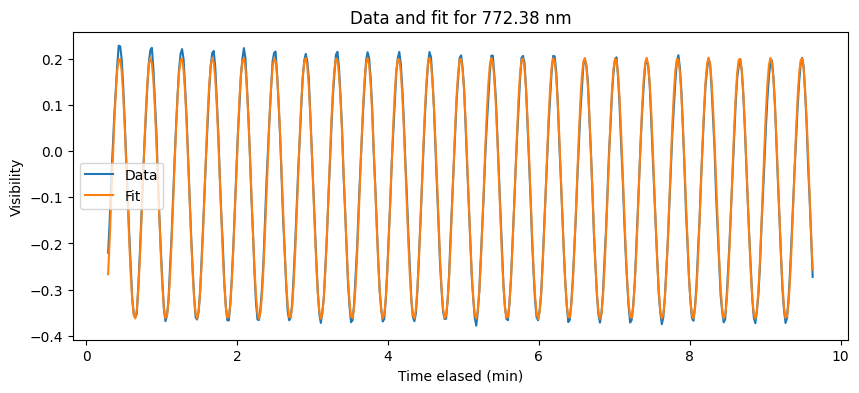

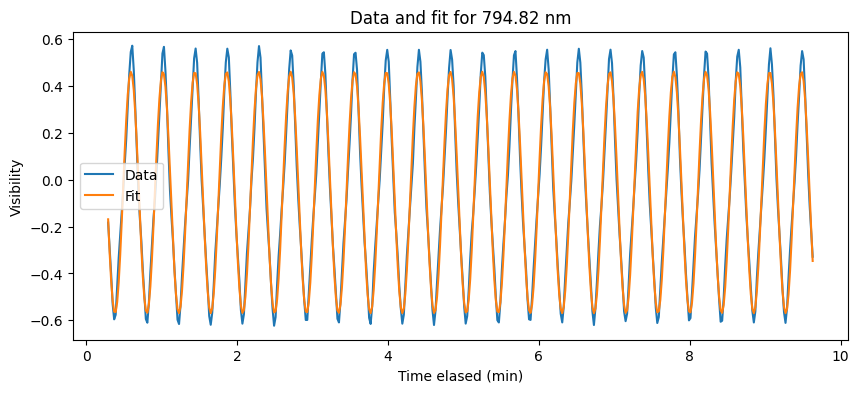

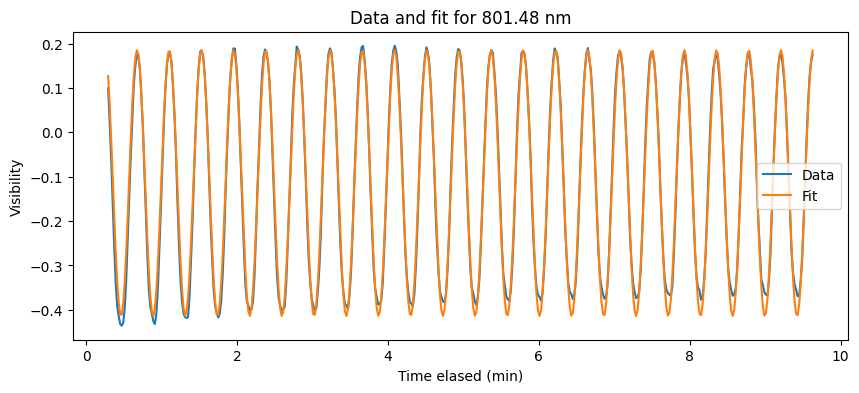

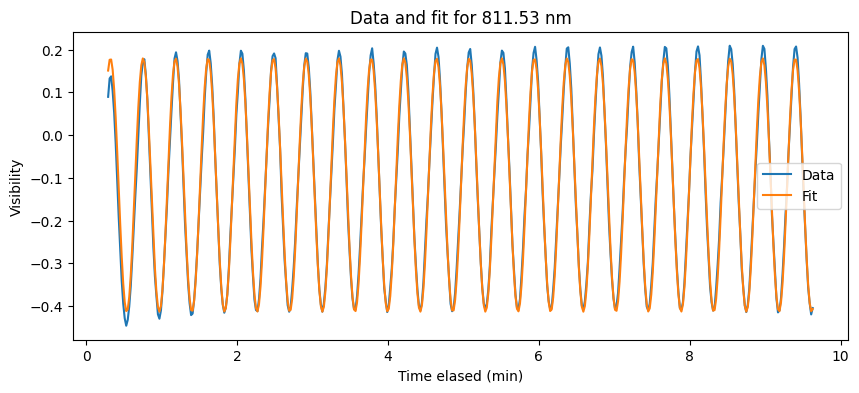

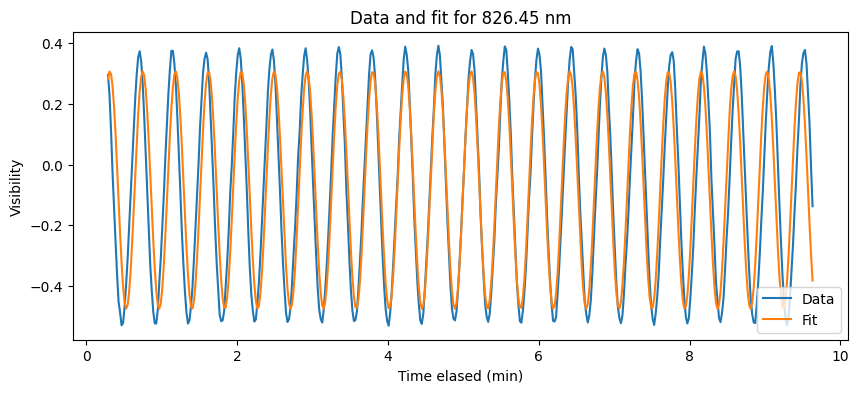

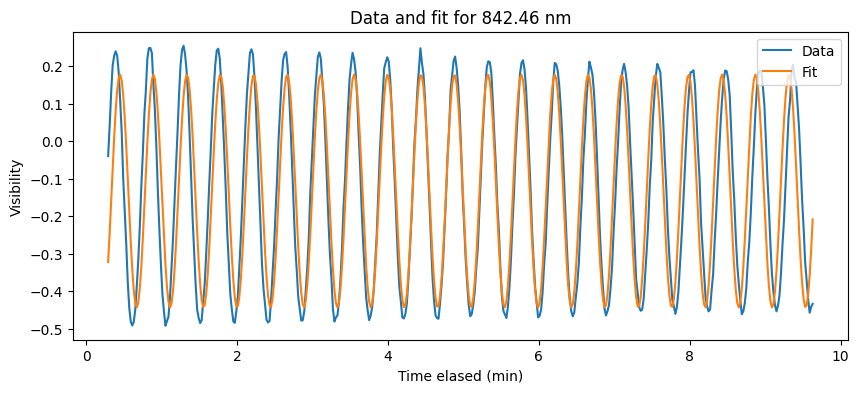

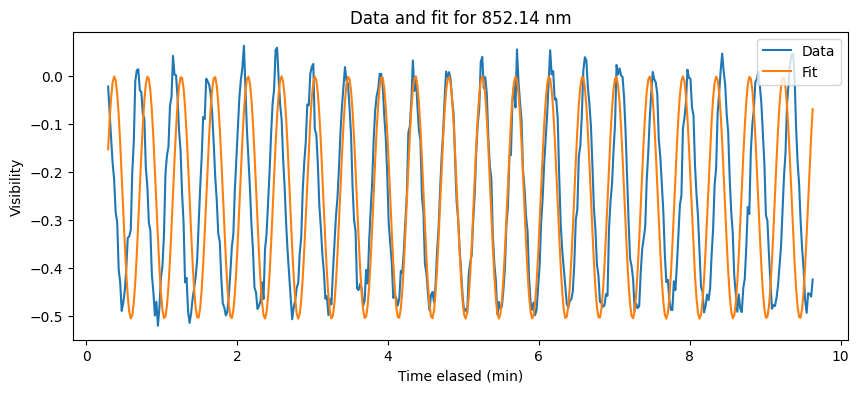

In [66]:
for j, spot in spot_df.iloc[::2].iterrows():
    i = j // 2
    hist = limited_hist_vals[i]
    result = results[i]
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(limited_centers,hist,label='Data')
    fitted_func = model.eval(result.params,x=limited_centers)
    ax.plot(limited_centers,fitted_func,label='Fit')
    ax.set_title(f"Data and fit for {spot['wavelength(nm)']} nm")
    ax.set_xlabel('Time elased (min)')
    ax.set_ylabel('Visibility')
    ax.legend()

#### Exclude the following spot indices to be excluded from the path length difference search (count from 0, top-down from the graphs above) due to bad fit

In [67]:
exclude_list = [11, 12, 13]

#### Print all fitted parameters

In [68]:
for i, spot in spot_df.iloc[::2].iterrows():
    print(f"Spot {i//2+1:2} ({spot['wavelength(nm)']:.2f} nm):", end=' ')
    result = results[i//2]
    for name in list(result.params):
        print(f"{name} = {result.params[name].value:.4f}", end=',   ')
    print()

Spot  1 (696.54 nm): a = 0.7474,   angfreq = 17.0085,   phase = 2.0125,   d = -0.0837,   
Spot  2 (706.72 nm): a = 0.7301,   angfreq = 16.7558,   phase = 1.0963,   d = -0.0179,   
Spot  3 (714.70 nm): a = 0.4709,   angfreq = 16.5597,   phase = 0.0895,   d = -0.0194,   
Spot  4 (727.29 nm): a = 0.7114,   angfreq = 16.2657,   phase = 0.5856,   d = -0.0230,   
Spot  5 (738.40 nm): a = 0.6504,   angfreq = 16.0108,   phase = -0.3121,   d = -0.1325,   
Spot  6 (750.39 nm): a = 0.3656,   angfreq = 15.7316,   phase = 0.2788,   d = -0.1726,   
Spot  7 (763.51 nm): a = 0.5445,   angfreq = 15.4655,   phase = 0.4162,   d = 0.0065,   
Spot  8 (772.38 nm): a = 0.2833,   angfreq = 15.2852,   phase = 1.1320,   d = -0.0803,   
Spot  9 (794.82 nm): a = 0.5150,   angfreq = 14.8404,   phase = -0.9377,   d = -0.0545,   
Spot 10 (801.48 nm): a = 0.2997,   angfreq = 14.7224,   phase = -2.0634,   d = -0.1143,   
Spot 11 (811.53 nm): a = 0.2963,   angfreq = 14.5331,   phase = 3.1961,   d = -0.1167,   
Spot 12 

#### Store the final results in a dictionary to be used later

In [69]:
final_params = {}
for pname in results[0].params:
    plist = []
    for i, spot in spot_df.iloc[::2].iterrows():
        plist.append(results[i//2].params[pname].value)
    final_params[pname] = plist

#### Graph frequencies vs expected frequencies

At this point, at least with no uncertainty provided to the fit model, the working methods don't estimate uncertainty on fit parameters.

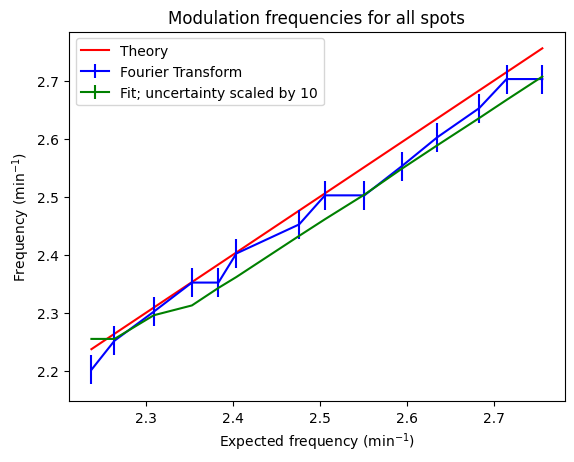

In [70]:
expected_freqs = np.array(spot_df['expected_freq_max(inv min)'])[::2]

fourier_freqs = np.array(spot_df['freq_max(inv min)'])[::2]
#uncertainty from frequency resolution
df = 1./(bin_centers_rt[-1]+bin_centers_rt[1]-2*bin_centers_rt[0])
n_spots = len(spot_df)//2
fourier_freqs_unc = 0.5*df*np.ones(n_spots) #half the finest resolution

fit_freqs = 0.5 * np.array(final_params['angfreq']) / np.pi
#get all original values and uncertainties as a list of dictionaries of ufloats
param_ufloats = []
for i, result in enumerate(results):
    param_ufloats.append(result.params.create_uvars())
#uncertainty from the fit 
fit_freqs_unc = []
for param_dict in param_ufloats:
    unc = 0.5 * param_dict['angfreq'].s / np.pi #uncertainty in angfreq
    fit_freqs_unc.append(unc)
fit_freqs_unc = np.array(fit_freqs_unc)
erscale = 10 #the uncertainty is small, but we should show meaningful errorbars

fig, ax = plt.subplots()
ax.plot(expected_freqs,expected_freqs,label='Theory',ls='-',color='red')
ax.errorbar(expected_freqs,fourier_freqs,yerr=fourier_freqs_unc,label='Fourier Transform',ls='solid',color='blue')
ax.errorbar(expected_freqs,fit_freqs,yerr=erscale*fit_freqs_unc,
            label=f'Fit; uncertainty scaled by {erscale}',ls='solid',color='green')
ax.set_title("Modulation frequencies for all spots")
ax.set_xlabel('Expected frequency ($\mathrm{min^{-1}}$)')
ax.set_ylabel('Frequency ($\mathrm{min^{-1}}$)')
#ax.set_ylim(0,2.9)
ax.legend()

#### Explore the difference between expected and observed frequencies

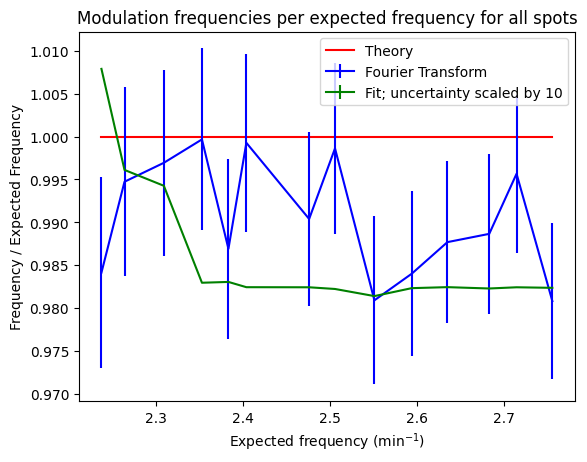

In [71]:
#this only works if expected_freqs has no uncertainty

fig, ax = plt.subplots()
ax.plot(expected_freqs,expected_freqs/expected_freqs,label='Theory',ls='-',color='red')

ax.errorbar(expected_freqs,fourier_freqs/expected_freqs,yerr=fourier_freqs_unc/expected_freqs,label='Fourier Transform',ls='solid',color='blue')

ax.errorbar(expected_freqs,fit_freqs/expected_freqs,yerr=erscale*fit_freqs_unc/expected_freqs,
            label=f'Fit; uncertainty scaled by {erscale}',ls='solid',color='green')

ax.set_title("Modulation frequencies per expected frequency for all spots")
ax.set_xlabel('Expected frequency ($\mathrm{min^{-1}}$)')
ax.set_ylabel('Frequency / Expected Frequency')
ax.legend()

#### Walk back all fringes by a given distance *in both directions* and count close maxima in bins

We have to exclude the obviously "bad" fits. At this time those are of the last 3 wavelengths.

In [72]:
t_exp = 7. #s
mov_per_exp = 10 
t_tot = 20. * 60. #s
mov_dist = 2.5 #microns

In [73]:
#distances (except for nm wavelengths in sellmeier eqn) in microns, time in seconds

#wavelengths = np.array([wl for wl in spot_df['wavelength(nm)']]) #nm
#output_numbers = np.array([wl for wl in spot_df['wavelength(nm)']])

#convert time in MINUTES to prism thickness change in MICRONS
time_to_thickness = 60. * np.tan(np.pi/180.) * mov_per_exp * mov_dist / t_exp

#make arrays of points representing maxima in microns
@njit()
def find_maxima_locations(angfreqs, phases, exclude_list, max_path_view = 2000):
    maxima_locations = []
    for i, (angfreq, phase) in enumerate(zip(angfreqs, phases)):
        if i in exclude_list: # SKIP BAD FITS MANUALLY
            continue
        angfreq = angfreq / time_to_thickness
        path_view = 0.0
        specific_maxima_locations = [(0.5*np.pi-phase)/angfreq] #time, minutes
        n = 1
        while path_view < max_path_view: #to make this monotonic
            inv_angfreq = 1./angfreq
            specific_maxima_locations.append((np.pi*(0.5+2*n)-phase)*inv_angfreq)
            specific_maxima_locations.append((np.pi*(0.5-2*n)-phase)*inv_angfreq)
            path_view += 2.*np.pi*inv_angfreq
            n += 1
        maxima_locations.append(np.sort(np.array(specific_maxima_locations)))
    return maxima_locations

@njit() #for each spot, for each edge, loop over a subset of maxima loc's and see whether one's in there.
def bin_maxima(maxima_locations, path_view = 2000.0, width=0.053, delta=0.01):
    max_bin_edges = np.arange(-path_view, path_view, delta) #LEFT edges of the bins
    max_hist = np.zeros(len(max_bin_edges)) #histogram with bin values.
    for i, specific_maxima_locations in enumerate(maxima_locations): #specific, as in, at a specific wavelength
        for j, edge in enumerate(max_bin_edges):
            for max_loc in specific_maxima_locations:
                if edge < max_loc < (edge + width): #stop if we reach it
                    max_hist[j] += 1
                    break
                elif max_loc > (edge + width): #stop if we pass it
                    break
    bin_centers = max_bin_edges + 0.5 * width
    return max_hist, bin_centers

print(f"Prism thickness changes at a rate of {time_to_thickness} microns per minute")

Prism thickness changes at a rate of 3.7403710560466257 microns per minute


In [74]:
#def sellmeier_bk7(wavelength): # Measured in nm
#    return np.sqrt(1 + 1.03961212*wavelength**2/(wavelength**2-6.00069867e3) +
#                   0.231792344*wavelength**2/(wavelength**2-2.00179144e4) + 
#                   1.01046945*wavelength**2/(wavelength**2-1.03560653e8))
#def edlen_standard_air(wavelength): #measured in microns
#    return 1 + #...

#### Calculate and graph the histogram of maxima locations. Ideally, the "correct" absolute path length will have the wavelength the closest together and in wavelength order.

In [75]:
width = 0.6 #microns of prism thickness change

angfreqs = final_params['angfreq']
#angfreqs = fourier_freqs * np.pi * 2.
#angfreqs = expected_freqs * np.pi * 2.

maxima_locations = find_maxima_locations(angfreqs, final_params['phase'], exclude_list)
max_hist, bin_centers = bin_maxima(maxima_locations, width=width)

In [76]:
for i, spot in spot_df.iloc[::2].iterrows():
    if i//2 in exclude_list:
        continue
    res = results[i//2]
    uv = res.params.create_uvars()['angfreq']
    specific_max_loc = maxima_locations[i//2]
    print(f"Spot {i//2+1:2} ({spot['wavelength(nm)']:.2f} nm): Error at 1000 fringes is {100.*1000.*uv.s/uv.n:.2f} percent of a fringe; about {len(specific_max_loc)//2} fringes on each side.")

Spot  1 (696.54 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1448 fringes on each side.
Spot  2 (706.72 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1426 fringes on each side.
Spot  3 (714.70 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1410 fringes on each side.
Spot  4 (727.29 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1385 fringes on each side.
Spot  5 (738.40 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1363 fringes on each side.
Spot  6 (750.39 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1339 fringes on each side.
Spot  7 (763.51 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1317 fringes on each side.
Spot  8 (772.38 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1301 fringes on each side.
Spot  9 (794.82 nm): Error at 1000 fringes is 0.00 percent of a fringe; about 1263 fringes on each side.
Spot 10 (801.48 nm): Error at 1000 fringes is 0.00 perc

C:\Users\tdavd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [77]:
#%matplotlib widget

An instance of the most maxima occurs at index 375844, which is x = 1758.74, with a total of 11.0 maxima.


(0.0, 11.5)

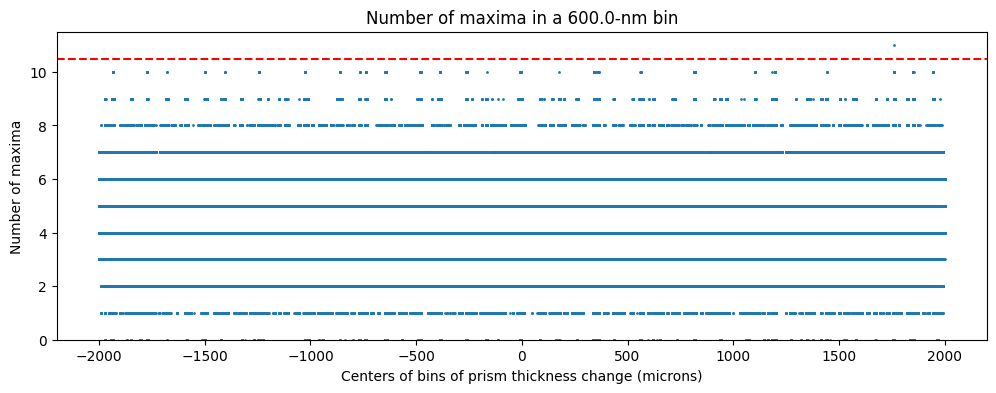

In [78]:
histmax_index = np.argmax(max_hist)
histmax_position = bin_centers[np.argmax(max_hist)]
histmax = np.max(max_hist)

print(f"An instance of the most maxima occurs at index {histmax_index}, which is x = {histmax_position}, with a total of {histmax} maxima.")

threshold = len(maxima_locations)-0.5

fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(bin_centers, max_hist, s=1)
ax.axhline(threshold,color='red',ls='--')
ax.set_xlabel("Centers of bins of prism thickness change (microns)")
ax.set_ylabel("Number of maxima")
ax.set_title(f"Number of maxima in a {width*1000.}-nm bin")
ax.set_ylim(0,threshold+1)
#ax.set_xlim(-10, 10)

#### Graph the fit functions together and manually look closer at promising locations.

Note that by default, matplotlib places plots on top of each other in the order they are added to a figure.

Text(0, 0.5, 'Normalized shifted fit amplitude')

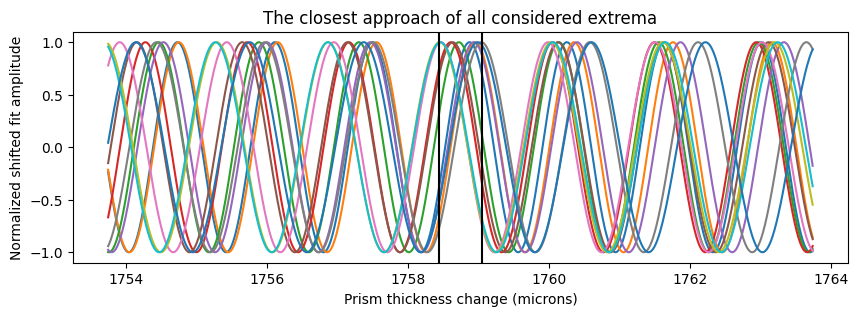

In [79]:
plot_bound_left = histmax_position - 5
plot_bound_right = histmax_position + 5
line_left = histmax_position - 0.5*width
line_right = histmax_position + 0.5*width

fig, ax = plt.subplots(figsize=(10,3))
x = np.linspace(plot_bound_left,plot_bound_right, 20000)

#FIXME: MAKE ANGFREQ IN INVERSE MICRONS
for i, spot in spot_df.iloc[::2].iterrows():
    if i//2 in exclude_list:
        continue
    plot_params = lmfit.create_params()
    for key in final_params.keys():
        plot_params.add(key,value=final_params[key][i//2])
    plot_params['angfreq'].set(plot_params['angfreq'] / time_to_thickness)
    model_plot = model.eval(params=plot_params,x=x)
    ax.plot(x, 2.*(model_plot - 0.5*(np.max(model_plot)+np.min(model_plot)))/(np.max(model_plot)-np.min(model_plot)))

#manually bound maxima
if plot_bound_left < line_left:
    ax.axvline(line_left,color='k')
if plot_bound_right > line_right:
    ax.axvline(line_right,color='k')

ax.set_title("The closest approach of all considered extrema")
ax.set_xlabel("Prism thickness change (microns)")
ax.set_ylabel("Normalized shifted fit amplitude")

#### Plot the order of fringes at the closest approach

If this difference is purely due to slight smearing due to passing through a small length of BK7, for example, one expects a monotonically increasing function (diffrent spots with the same wavelength should be at the same location).

We have located 11 maxima in the selected region.


Text(0, 0.5, 'Maximum location (microns)')

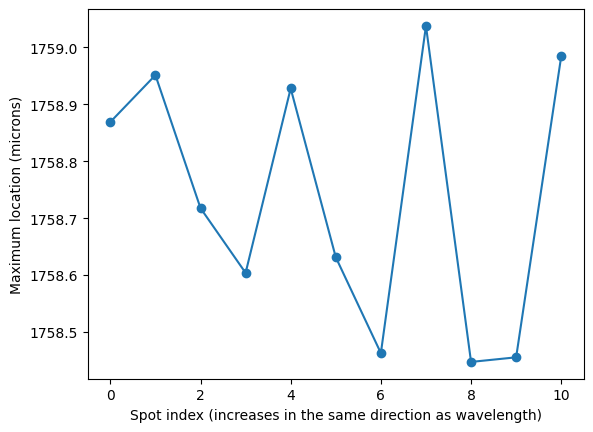

In [80]:
max_order_list = []
for i, specific_max_locs in enumerate(maxima_locations):
    for max_loc in specific_max_locs:
        if line_left < max_loc < line_right:
            max_order_list.append([i,max_loc])
max_order_array = np.array(max_order_list)
            
print(f"We have located {len(max_order_list)} maxima in the selected region.")

fig, ax = plt.subplots()
ax.plot(max_order_array[:,0],max_order_array[:,1],marker='o')
ax.set_xlabel('Spot index (increases in the same direction as wavelength)')
ax.set_ylabel('Maximum location (microns)')

#### Comments:

*Implicit assumptions that may or may not have made it into the code*: The camera is the Timepix, the MZ phase shifted using prisms,  

*The "mod" argument*: Real waves shouldn't theoretically all reach peaks at *exactly* the same place in space more than once, since that would require periods related by a factor of a rational number. Perhaps they'll still get arbitrarily close with some ballpark frequency, but I don't know if that frequency is constant and reliable. If my reasoning is correct, we can't say we have the correct value mod a *specific number*. I will say that on the graph above, in multiple places maxima do approach each other closely. I just don't know if these occur at a constant rate.

*The frequency vs. expected frequency graph*: Theory and fit are both very precise, look to have very close slopes to within uncertainty but a significant offset, and strangely, bound the Fourier maxima (may be spurious). We must test with both the fit and expected frequencies and explain their difference.

*If we take another dataset:* We can take a longer dataset and optimize every parameter to be able to increase the value of path length differences we can measure. I think this would result in significantly better results, perhaps allowing us to extend the resolvable path length difference to inches. We could also use better beamsplitters which don't require the light to be sent through (as) significant lengths of glass.

*Generalization to spectrally continous light*: This code assumes that within one Timepix pixel bin, there is only one modulation frequency. The fact that some of our points are clearly doublet emissions indicates that we *can* handle a finite range of frequencies binned together provided that the path length difference is not so long that the difference in phases between nearby frequencies gets too high. This means the frequencies have to be very close.

*Changes due to using visibility instead of counts*: It was difficult to fit to these functions with many methods for some reason; only four worked well and those failed for the last 3 visibility functions. Having tested new fit functions, a new difficulty is that none of the ones that work give us an idea of the uncertainty on the parameters (perhaps without uncertainty on the visibility which comes from signal uncertainty... it is an open question how to interpret it). The different fit functions must also produce slightly different parameters, with differential_evolution showing all 11 considered functions to have a maxima within 560 nm near 400 microns in the + direction, but ampgo needed 600 nm and showed it near 1800 microns in the + direction. This means the fits disagree significantly about results-- it would be nice to have an idea of the uncertainty on the parameters! This is on top of being unable to predict where all the maxima should get close and how close they should get.